## Data preparation

In [1]:
import cv2
import os
import numpy as np
import glob
import csv
from matplotlib import pyplot as plt
import random
import tensorflow as tf
import gast
import math

import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.python.framework import ops


BASE_PATH = 'GTSRB/Final_Training/Images'
TEST_PATH = 'GTSRB/Final_Test'
np.random.seed(1)

/home/tymek/programs/python/ripo/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tymek/programs/python/ripo/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tymek/programs/python/ripo/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tymek/programs/python/ripo/venv

## Functions

In [2]:
def resize():
    counter = 0
    for dirname in os.listdir(BASE_PATH):
        for filename in os.listdir(os.path.join(BASE_PATH, dirname)):
            if filename.endswith(".ppm"):
                image_path = os.path.join(BASE_PATH, dirname, filename)
                im = cv2.imread(image_path)
                resized_im = cv2.resize(im, (32, 32))
                cv2.imwrite(image_path, resized_im)

In [3]:
def sanity_check():
    counter = 0
    for dirname in os.listdir(BASE_PATH):
        for filename in os.listdir(os.path.join(BASE_PATH, dirname)):
            if filename.endswith(".ppm"):
                image_path = os.path.join(BASE_PATH, dirname, filename)
                im = cv2.imread(image_path)
                if im.shape != (32, 32, 3):
                    counter += 1
    print(counter)

In [4]:
def load_dataset():
    filelist = glob.glob(f'{BASE_PATH}/*/*.ppm')
    testlist = glob.glob(f'{TEST_PATH}/Images/*.ppm')
    X_train = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )
    X_test = np.array([np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist])

    Y_train = np.array([np.zeros(43) for fname in filelist])
    for i,fname in enumerate(filelist):
        Y_train[i][int(fname.split('/')[3])]=1

    with open(f'{TEST_PATH}/GT-final_test.csv') as csvfile:
        spamreader = csv.reader(csvfile,delimiter=';')
        data = list(spamreader)
        data.pop(0)

    Y_test = np.array([np.zeros(43) for fname in testlist])
    for i,fname in enumerate(testlist):
        image_name = fname.split('/')[3]
        image_number = int(image_name.split('.')[0])
        classid = int(data[image_number][7])
        Y_test[i][classid]=1

    return X_train, Y_train, X_test, Y_test

In [5]:
def show_image(index, X, Y):
    plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB).astype('float32'))
    plt.show()
    print('Belongs to class nr: ' + str(int(np.where(Y[index]==1)[0])))

(39209, 32, 32, 3)
(39209, 43)


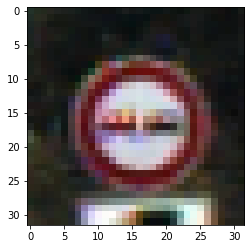

Belongs to class nr: 13


In [6]:
X_train, Y_train, X_test, Y_test = load_dataset()
print(X_train.shape)
print(Y_train.shape)
show_image(random.randint(0,12629),X_test, Y_test)

## Deep learning functions and its tests

In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype='float')
    Y = tf.placeholder(shape=[None, n_y], dtype='float')
    return X, Y

In [8]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [9]:
def forward_propagation(X, parameters):
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    F = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(F, 43, activation_fn=None)

    return Z3

In [10]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))

    return cost

In [11]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k*mini_batch_size : (k+1)*mini_batch_size, :,  :, :]
        mini_batch_Y = shuffled_Y[k*mini_batch_size : (k+1)*mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [44]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 20, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run(fetches=[optimizer, cost],
                                         feed_dict={X: minibatch_X,
                                                    Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        print("Train Accuracy:", train_accuracy)
#         test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
#         print("Test Accuracy:", test_accuracy)

Cost after epoch 0: 2.794398
Cost after epoch 5: 1.664728
Cost after epoch 10: 1.533053
Cost after epoch 15: 1.462609


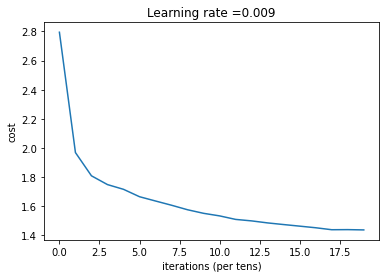

Train Accuracy: 0.55387795


In [45]:
model(X_train, Y_train, X_test, Y_test)